<a href="https://colab.research.google.com/github/wahomeJohn/ClassGoals/blob/main/Recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing  libraries

In [2]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 26.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619396 sha256=fd8cfa9862b80540e8de39aa8c8ee1ff26a5d7f7b65aa090381abe77712d17db
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate

Loading datasets

In [30]:
column_names = ['userId','productId','rating','timestamp']
df = pd.read_csv('/content/ratings_Electronics (1).csv',names= column_names)
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982403 entries, 0 to 1982402
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  float64
dtypes: float64(2), object(2)
memory usage: 60.5+ MB


In [32]:
df.shape

(1982403, 4)

In [33]:
df.describe()

,rating,timestamp
count,1.982402e+06,1.982402e+06
mean,3.982455e+00,1.272077e+09
std,1.396604e+00,9.502348e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.206922e+09
50%,5.000000e+00,1.278806e+09
75%,5.000000e+00,1.358381e+09
max,5.000000e+00,1.406074e+09


In [34]:
df.isnull().sum()

userId       0
productId    1
rating       1
timestamp    1
dtype: int64

In [35]:
df1=df.dropna(inplace=True)

Explanatory Analysis

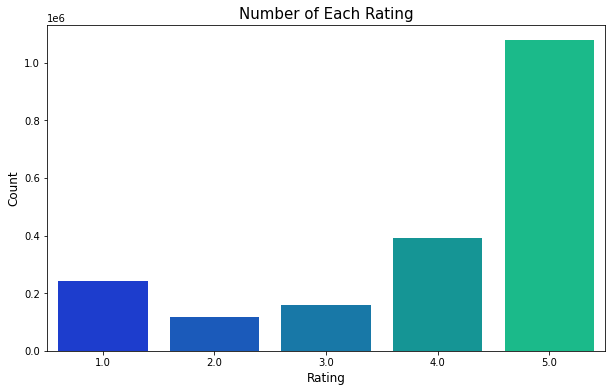

In [37]:
#First we analyze the number of recorded ratings
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=df, palette='winter')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of Each Rating', fontsize=15)
plt.show()

In [38]:
#We study the distribuition of number of ratings and mean ratings recorded for each product.
df_rating=pd.DataFrame({'Number of Rating':df.groupby('productId').count()['rating'], 'Mean Rating':df.groupby('productId').mean()['rating']})

In [39]:
df_rating.head()

,Number of Rating,Mean Rating
productId,,
0132793040,1,5.000000
0321732944,1,5.000000
0439886341,3,1.666667
0511189877,6,4.500000
0528881469,27,2.851852


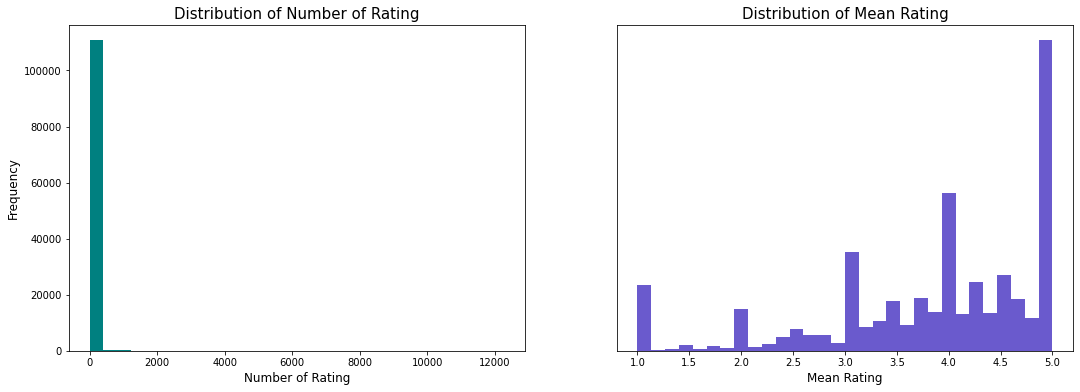

In [40]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(x='Number of Rating',data=df_rating,bins=30,color='teal')
plt.title('Distribution of Number of Rating', fontsize=15)
plt.xlabel('Number of Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='Mean Rating',data=df_rating,bins=30, color='slateblue')
plt.title('Distribution of Mean Rating', fontsize=15)
plt.xlabel('Mean Rating', fontsize=12)
plt.yticks([])
plt.show()

*From these histograms we can see that most of the number of ratings are between 0 and 1825, and most of the products have a mean rating of 5.*

<Figure size 576x432 with 0 Axes>

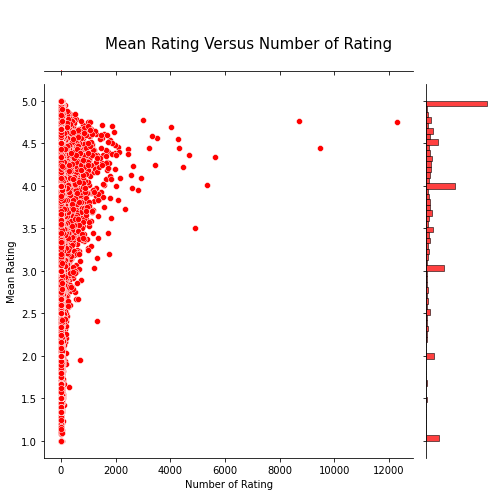

In [42]:
#We create a scatter plot to observe the relationship between Number of Rating and Mean Rating.
plt.figure(figsize=(8,6))
sns.jointplot(x='Number of Rating', y='Mean Rating',data=df_rating,color='r', height=7)
plt.suptitle('Mean Rating Versus Number of Rating', fontsize=15, y=0.92)

plt.show()

Recommender system-
Populality based recommender

All we have to do is sort our products based on ratings, and display the top products of our list

In [43]:
#Creating a metric to score or rate the products
df_rating['Mean Rating'].mean()

3.851366685217081

In [44]:
df_rating['Number of Rating'].quantile(q=0.9)

30.0

In [45]:
#we filter the productes that qualify in the chart  and put them in a new  dataframe
df_filtered=df_rating[df_rating['Number of Rating']>df_rating['Number of Rating'].quantile(q=0.9)]

In [46]:
df_filtered.shape

(10995, 2)

In [47]:
def product_score(x):
    v=x['Number of Rating']
    m=df_rating['Number of Rating'].quantile(q=0.9)
    R=x['Mean Rating']
    C=df_rating['Mean Rating'].mean()
    return ((R*v)/(v+m))+((C*m)/(v+m))

In [48]:
df_filtered['score']=df_filtered.apply(product_score, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
df_filtered.head()

,Number of Rating,Mean Rating,score
productId,,,
0594481813,31,4.225806,4.041656
0972683275,1051,4.470980,4.453784
1400501466,250,3.560000,3.591218
1400501520,82,4.243902,4.138759
1400501776,139,3.884892,3.878941


In [50]:
df_highscore=df_filtered.sort_values(by='score', ascending=False).head(10)

In [51]:
df_highscore

,Number of Rating,Mean Rating,score
productId,,,
B00125Y0NU,525,4.841905,4.788362
B000053HC5,166,4.945783,4.778270
B000B9RI14,2996,4.775701,4.766537
B000053HH5,347,4.841499,4.762708
B000I1X3W8,253,4.869565,4.761629
B000LRMS66,8715,4.756627,4.753521
B0019EHU8G,12285,4.754497,4.752297
B001BTCSI6,217,4.875576,4.751178
B00007GQLU,547,4.787934,4.739239


In [52]:
df_highscore.index

Index(['B00125Y0NU', 'B000053HC5', 'B000B9RI14', 'B000053HH5', 'B000I1X3W8',
       'B000LRMS66', 'B0019EHU8G', 'B001BTCSI6', 'B00007GQLU', 'B00006I53X'],
      dtype='object', name='productId')